# RBMs and DBNs

### Load mnist datasets

In [1]:
import pandas as pd
from torchvision.datasets import FashionMNIST, KMNIST, MNIST

mnist = MNIST(
    root="data/mnist",
    download=True,
)

mnist_test = MNIST(root="data/mnist", download=True, train=False)

fashion = FashionMNIST(
    root="data/fmnist",
    download=True,
)
fashion_test = FashionMNIST(root="data/fmnist", download=True, train=False)

kuzushiji = KMNIST(
    root="data/kmnist",
    download=True,
)
kuzushiji_test = KMNIST(root="data/kmnist", download=True, train=False)

In [2]:
mnist_train_data = mnist.data
mnist_train_labels = mnist.train_labels.numpy()
mnist_test_data = mnist_test.data
mnist_test_labels = mnist_test.targets.numpy()

fashion_train_data = fashion.train_data
fashion_train_labels = fashion.train_labels.numpy()
fashion_test_data = fashion_test.data
fashion_test_labels = fashion_test.targets.numpy()

kuzushiji_train_data = kuzushiji.train_data
kuzushiji_train_labels = kuzushiji.train_labels.numpy()
kuzushiji_test_data = kuzushiji_test.data
kuzushiji_test_labels = kuzushiji_test.targets.numpy()

C:\Users\piotr\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\datasets\mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\piotr\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\datasets\mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


### Preprocess datasets

In [3]:
import numpy as np

Histogram normalization

In [4]:
def normalize(images):

    histograms = np.apply_along_axis(
        np.bincount, 1, images.reshape(images.shape[0], -1), minlength=256
    )

    cdf = histograms.cumsum(axis=1)
    cdf_min = cdf[:, 0][
        :, None
    ]  # Minimum of the CDF (first non-zero element in each row)

    # Normalize the CDF for each image
    cdf_m = ((cdf - cdf_min) * 255) / (cdf.max(axis=1)[:, None] - cdf_min)

    cdf_m = cdf_m.astype(np.uint8)

    # Apply normalized CDF to each image
    normalized_images = cdf_m[
        np.arange(images.shape[0])[:, None, None], images
    ]  #  Broadcasting across images and index

    return normalized_images

In [5]:
mnist_train_data = normalize(mnist_train_data) > 63
mnist_test_data = normalize(mnist_test_data) > 63

fashion_train_data = normalize(fashion_train_data) > 63
fashion_test_data = normalize(fashion_test_data) > 63

kuzushiji_train_data = normalize(kuzushiji_train_data) > 99
kuzushiji_test_data = normalize(kuzushiji_test_data) > 99

### Display images

In [6]:
import matplotlib.pyplot as plt


def display_images(images, title=""):
    # Ensure we only display up to the number of images available
    num_images = images.shape[0]

    # Set up a grid for the images
    cols = 5
    rows = (
        num_images + cols - 1
    ) // cols  # Calculate rows needed for the number of images

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(10, 2 * rows))
    fig.suptitle(title)

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(images[i], cmap="gray")
        ax.axis("off")

    plt.plot()

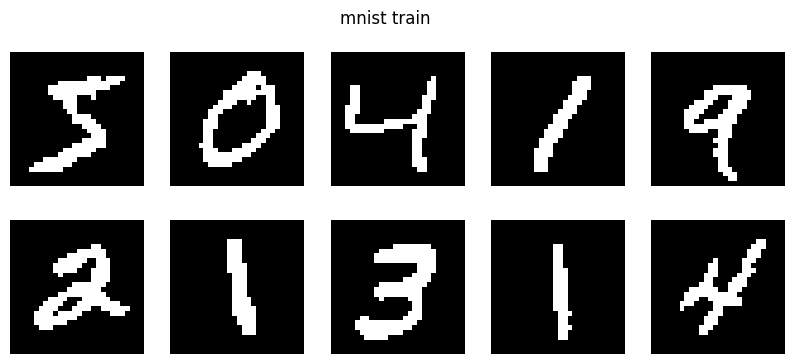

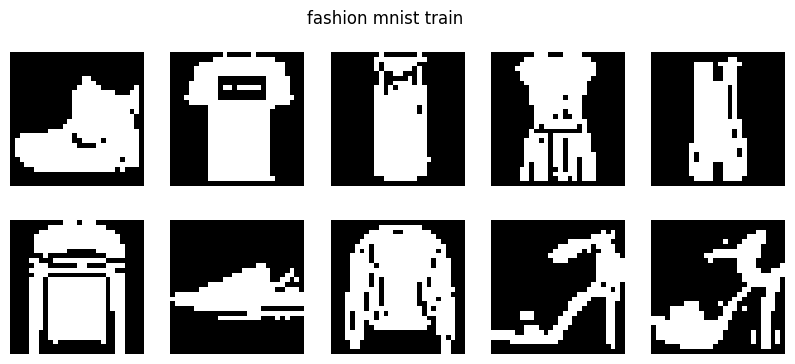

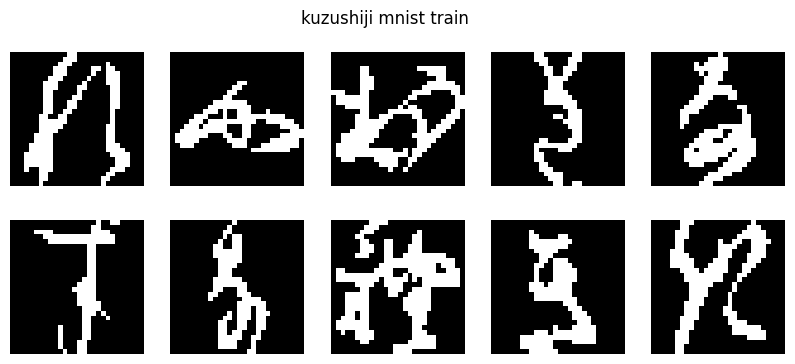

In [7]:
display_images(mnist_train_data[:10], "mnist train")
display_images(fashion_train_data[:10], "fashion mnist train")
display_images(kuzushiji_train_data[:10], "kuzushiji mnist train")

In [8]:
mnist = [mnist_train_data, mnist_train_labels, mnist_test_data, mnist_test_labels]
fashion = [
    fashion_train_data,
    fashion_train_labels,
    fashion_test_data,
    fashion_test_labels,
]
kuzushiji = [
    kuzushiji_train_data,
    kuzushiji_train_labels,
    kuzushiji_test_data,
    kuzushiji_test_labels,
]

datasets = [mnist, fashion, kuzushiji]
names = ("mnist", "fashion mnist", "kuzushiji mnist")

# Task 1 - RBM feature extraction

### Baseline

In [9]:
import pandas as pd


# retunrs a dataframe with socres for each class and scores combined
def get_score_df(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)

    result_df = pd.DataFrame(columns=["label", "auroc", "f1", "prec", "rec"])
    classes = np.unique(y_test)  # Assuming y_train contains all classes
    for cls in classes:
        binary_y_test = (y_test == cls).astype(int)
        binary_y_pred = (y_pred == cls).astype(int)

        auroc = roc_auc_score(binary_y_test, y_prob[:, cls])
        f1 = f1_score(binary_y_test, binary_y_pred)
        precision = precision_score(binary_y_test, binary_y_pred)
        recall = recall_score(binary_y_test, binary_y_pred)

        result_df.loc[result_df.shape[0]] = [cls, auroc, f1, precision, recall]

    auroc = roc_auc_score(y_test, y_prob, multi_class="ovr", average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    result_df.loc[result_df.shape[0]] = ["all", auroc, f1, precision, recall]

    return result_df

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

baseline_dataframes = []
for data, name in zip(datasets, names):
    print(f"Training for {name}")
    X_train, y_train, X_test, y_test = data
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    clf = LogisticRegression(n_jobs=-1, random_state=42)

    clf.fit(X_train, y_train)

    result_df = get_score_df(clf, X_test, y_test)

    baseline_dataframes.append(result_df)

    print(result_df)
    print()

Training for mnist
   label     auroc        f1      prec       rec
0    0.0  0.998814  0.959235  0.946375  0.972449
1    1.0  0.998860  0.978929  0.975503  0.982379
2    2.0  0.989151  0.910440  0.930233  0.891473
3    3.0  0.992957  0.894325  0.883946  0.904950
4    4.0  0.995786  0.919028  0.913481  0.924644
5    5.0  0.988035  0.876147  0.896714  0.856502
6    6.0  0.997391  0.940691  0.929664  0.951983
7    7.0  0.993401  0.928188  0.932287  0.924125
8    8.0  0.990451  0.881183  0.875380  0.887064
9    9.0  0.992254  0.899651  0.906439  0.892963
10   all  0.993802  0.919936  0.920056  0.920100

Training for fashion mnist
   label     auroc        f1      prec     rec
0    0.0  0.979829  0.802165  0.789729  0.8150
1    1.0  0.997567  0.963489  0.977366  0.9500
2    2.0  0.965686  0.711067  0.712136  0.7100
3    3.0  0.986849  0.841231  0.822350  0.8610
4    4.0  0.968594  0.720773  0.697196  0.7460
5    5.0  0.997695  0.933197  0.952133  0.9150
6    6.0  0.921319  0.550725  0.5944

### Tune and train a pipeline

In [31]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

scoring_func = lambda true, pred: roc_auc_score(
    true, pred, multi_class="ovr", average="weighted"
)

multiclass_auroc_scorer = make_scorer(
    scoring_func, needs_proba=True, greater_is_better=True
)

rbm_dataframes = []
estims = []
for data, name in zip(datasets, names):
    print(f"Training for {name}")
    X_train, y_train, X_test, y_test = data
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    pipe = Pipeline(
        [
            ("rbm", BernoulliRBM(random_state=42)),
            ("logreg", LogisticRegression(random_state=42)),
        ]
    )

    param_grid = {
        "rbm__n_components": [64, 96, 128],  # Number of hidden units
        "rbm__learning_rate": [0.01, 0.1],  # Learning rate
        "rbm__batch_size": [5, 10, 15],  # Batch size
        "logreg__C": [0.5, 1.0],  # Regularization strength
    }

    clf = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=5,
        scoring=multiclass_auroc_scorer,
        n_jobs=-1,
        verbose=2,
    )

    clf.fit(X_train, y_train)

    print(clf.best_params_)
    estims.append(clf.best_estimator_)

    result_df = get_score_df(clf, X_test, y_test)

    rbm_dataframes.append(result_df)

    print(result_df)
    print()

C:\Users\piotr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Training for mnist
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'logreg__C': 1.0, 'rbm__batch_size': 1, 'rbm__learning_rate': 0.1, 'rbm__n_components': 32}
{'mean_fit_time': array([66.68658342]), 'std_fit_time': array([0.37103219]), 'mean_score_time': array([0.08888397]), 'std_score_time': array([0.02651333]), 'param_logreg__C': masked_array(data=[1.0],
             mask=[False],
       fill_value=1e+20), 'param_rbm__batch_size': masked_array(data=[1],
             mask=[False],
       fill_value=999999), 'param_rbm__learning_rate': masked_array(data=[0.1],
             mask=[False],
       fill_value=1e+20), 'param_rbm__n_components': masked_array(data=[32],
             mask=[False],
       fill_value=999999), 'params': [{'logreg__C': 1.0, 'rbm__batch_size': 1, 'rbm__learning_rate': 0.1, 'rbm__n_components': 32}], 'split0_test_score': array([0.94567386]), 'split1_test_score': array([0.9249838]), 'split2_test_score': array([0.92695858]), 'split3_test_score': array([0.93

KeyboardInterrupt: 

# TODO - Plot weights

# Task 2 - DBN